# 📊 Bias, Variance, and Generalization — Cell-by-Cell Portfolio Notebook

This notebook demonstrates core statistical learning concepts through a controlled dataset and clear, reproducible experiments.  
Each section is presented as a **self-contained “cell”** with outputs that can be directly used in a portfolio narrative.


## 0) Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, f1_score


Matplotlib is building the font cache; this may take a moment.


## 1) Dataset Overview (Printed Cell)

We start by loading a dataset and visualizing its structure.  
This provides a baseline understanding before model fitting.


,x,y
count,800.000000,800.000000
mean,-0.007898,-0.232436
std,0.983653,43.225726
min,-3.241267,-184.588923
25%,-0.702334,-28.554245
50%,0.012797,0.797153
75%,0.628666,27.191619
max,3.852731,134.562774


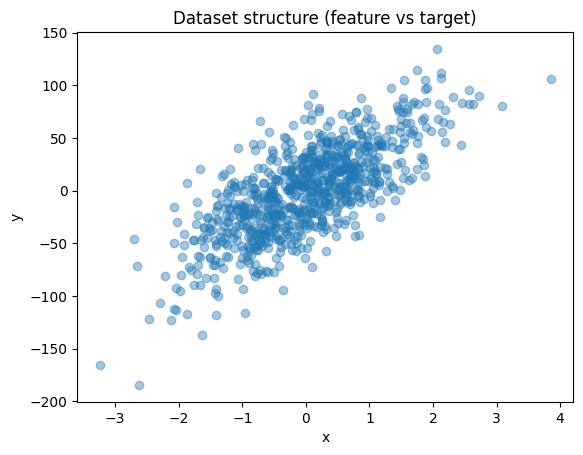

{'n_samples': 800, 'n_features': 1}

In [2]:
np.random.seed(42)

# Dataset for regression/generalization experiments
X, y = make_regression(
    n_samples=800,
    n_features=1,
    noise=30.0,
    random_state=42
)

# Introduce non-linear signal so model choice matters
y = y + 0.5 * (X[:, 0] ** 2)

df_overview = pd.DataFrame({"x": X[:, 0], "y": y})
display(df_overview.describe())

plt.scatter(X[:, 0], y, alpha=0.4)
plt.title("Dataset structure (feature vs target)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

{"n_samples": X.shape[0], "n_features": X.shape[1]}


## 2) Cell: Bias (Underfitting)

A model with insufficient flexibility fails to capture the structure of the data.  
Expected pattern: **train error remains high and test error remains high**.


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

bias_model = LinearRegression()
bias_model.fit(X_train, y_train)

pred_train = bias_model.predict(X_train)
pred_test = bias_model.predict(X_test)

bias_cell = {
    "cell": "Bias (Underfitting)",
    "model": "Linear Regression",
    "train_mse": mean_squared_error(y_train, pred_train),
    "test_mse": mean_squared_error(y_test, pred_test),
}

bias_cell


{'cell': 'Bias (Underfitting)',
 'model': 'Linear Regression',
 'train_mse': 881.5246286508352,
 'test_mse': 803.9959547472971}

## 3) Cell: Variance (Overfitting)

A highly flexible model can fit noise and become unstable across splits.  
Expected pattern: **very low train error but noticeably worse test error**.


In [4]:
variance_model = Pipeline([
    ("poly", PolynomialFeatures(degree=15, include_bias=False)),
    ("lin", LinearRegression())
])
variance_model.fit(X_train, y_train)

pred_train = variance_model.predict(X_train)
pred_test = variance_model.predict(X_test)

variance_cell = {
    "cell": "Variance (Overfitting)",
    "model": "Polynomial Regression (degree=15)",
    "train_mse": mean_squared_error(y_train, pred_train),
    "test_mse": mean_squared_error(y_test, pred_test),
}

variance_cell


{'cell': 'Variance (Overfitting)',
 'model': 'Polynomial Regression (degree=15)',
 'train_mse': 846.9457162548415,
 'test_mse': 262144760.75599995}

## 4) Cell: Bias–Variance Tradeoff (Complexity Sweep)

We vary model complexity and print train/test error to identify an optimal range.  
This supports model selection based on **generalization performance**.


,degree,train_mse,test_mse
0,1,881.524629,803.995955
1,2,876.891564,812.893161
2,3,871.715312,809.221045
3,4,870.865294,798.218501
4,5,870.800495,802.268211
5,6,869.865630,841.805810
6,7,868.553949,1380.982400
7,8,868.550677,1299.399886
8,9,864.934486,12911.951329
9,10,862.937472,18863.703627


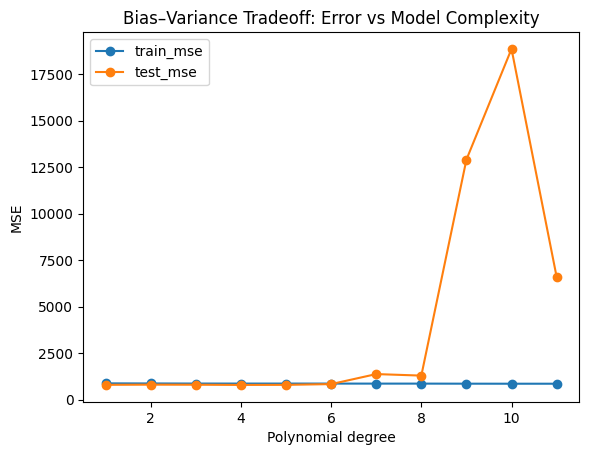

{'cell': 'Bias–Variance Tradeoff', 'best_degree_by_test_mse': 4}

In [5]:
rows = []
for deg in range(1, 12):
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
        ("lin", LinearRegression())
    ])
    model.fit(X_train, y_train)
    rows.append((
        deg,
        mean_squared_error(y_train, model.predict(X_train)),
        mean_squared_error(y_test, model.predict(X_test))
    ))

df_tradeoff = pd.DataFrame(rows, columns=["degree", "train_mse", "test_mse"])
display(df_tradeoff)

plt.plot(df_tradeoff["degree"], df_tradeoff["train_mse"], marker="o", label="train_mse")
plt.plot(df_tradeoff["degree"], df_tradeoff["test_mse"], marker="o", label="test_mse")
plt.title("Bias–Variance Tradeoff: Error vs Model Complexity")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.legend()
plt.show()

best_degree = int(df_tradeoff.loc[df_tradeoff["test_mse"].idxmin(), "degree"])
{"cell": "Bias–Variance Tradeoff", "best_degree_by_test_mse": best_degree}


## 5) Cell: Generalization Improvement (Regularization)

Regularization helps stabilize learning by controlling effective model complexity.  
We compare a regularized model to the unregularized baseline at the same polynomial degree.


In [6]:
target_degree = 6

unreg = Pipeline([
    ("poly", PolynomialFeatures(degree=target_degree, include_bias=False)),
    ("lin", LinearRegression())
])
unreg.fit(X_train, y_train)
unreg_test_mse = mean_squared_error(y_test, unreg.predict(X_test))

reg = Pipeline([
    ("poly", PolynomialFeatures(degree=target_degree, include_bias=False)),
    ("ridge", Ridge(alpha=10.0))
])
reg.fit(X_train, y_train)
reg_test_mse = mean_squared_error(y_test, reg.predict(X_test))

generalization_cell = {
    "cell": "Generalization (Regularization)",
    "degree": target_degree,
    "unregularized_test_mse": unreg_test_mse,
    "regularized_test_mse": reg_test_mse
}
generalization_cell


{'cell': 'Generalization (Regularization)',
 'degree': 6,
 'unregularized_test_mse': 841.8058099023758,
 'regularized_test_mse': 879.3915481094323}

## 6) Cell: Rare-Event Classification (Printed Metrics)

This section demonstrates why accuracy can be misleading when one class is rare.  
We print accuracy, recall, and F1 to highlight the importance of appropriate metrics.


In [7]:
X_imb, y_imb = make_classification(
    n_samples=5000,
    n_features=10,
    n_informative=3,
    n_redundant=2,
    weights=[0.98, 0.02],
    flip_y=0.01,
    random_state=42
)

Xtr, Xte, ytr, yte = train_test_split(
    X_imb, y_imb, test_size=0.25, stratify=y_imb, random_state=42
)

clf = LogisticRegression(max_iter=2000)
clf.fit(Xtr, ytr)
pred = clf.predict(Xte)

rare_event_cell = {
    "cell": "Rare-Event Classification",
    "accuracy": accuracy_score(yte, pred),
    "recall": recall_score(yte, pred, zero_division=0),
    "f1": f1_score(yte, pred, zero_division=0),
    "class_distribution": dict(zip(*np.unique(y_imb, return_counts=True)))
}
rare_event_cell


{'cell': 'Rare-Event Classification',
 'accuracy': 0.9808,
 'recall': 0.30303030303030304,
 'f1': 0.45454545454545453,
 'class_distribution': {0: 4869, 1: 131}}

## 7) Portfolio Summary (Printed Cell)

A compact summary table to paste into a README or portfolio description.


In [8]:
summary = pd.DataFrame([
    {"Cell": "Bias (Underfitting)", "Key Signal": "High train + high test error", "Typical Fix": "Increase model capacity / features"},
    {"Cell": "Variance (Overfitting)", "Key Signal": "Low train error + high test error", "Typical Fix": "Regularization / simpler model"},
    {"Cell": "Bias–Variance Tradeoff", "Key Signal": "Optimal complexity minimizes test error", "Typical Fix": "Model selection / CV"},
    {"Cell": "Generalization (Regularization)", "Key Signal": "Lower test error at same complexity", "Typical Fix": "Ridge/Lasso/early stopping"},
    {"Cell": "Rare-Event Classification", "Key Signal": "Accuracy misleading; recall/F1 reveal failure", "Typical Fix": "Resampling / thresholding / PR-AUC"},
])

summary


,Cell,Key Signal,Typical Fix
0,Bias (Underfitting),High train + high test error,Increase model capacity / features
1,Variance (Overfitting),Low train error + high test error,Regularization / simpler model
2,Bias–Variance Tradeoff,Optimal complexity minimizes test error,Model selection / CV
3,Generalization (Regularization),Lower test error at same complexity,Ridge/Lasso/early stopping
4,Rare-Event Classification,Accuracy misleading; recall/F1 reveal failure,Resampling / thresholding / PR-AUC
